# Left-Right Hands Recognition with CNNs

In this personal project, i want to explore the capabilities of CNN in identifying left hands from right hands, starting from pictures of hands in different positions and on several backgrounds. Alongside this notebook, I upload only a small portion of the whole set of images, being it too large for gitHub (200000+ frames).

1. **dataset generation**: To run an interesting experiment, we need a lot of images in a lot of location. With this goal, i recorded a lot of wideos of moving hands in different places: with a frequency of 60 fps, few minutes of videos are converted into a lot of pictures.
2. **frames generation**: With OpenCV library, we can easily convert a video in a sequence of frames, that is what we do. In particular, for the validation set, we saved only a frame out of 8, in order to better generalize. Indeed, two consecutive frames are very similar one to each other and in the val_set we rather want to have different frames.
3. The procedure of frames' generation is omitted here for the sake of simplicity.

The following are some images from our dataset:

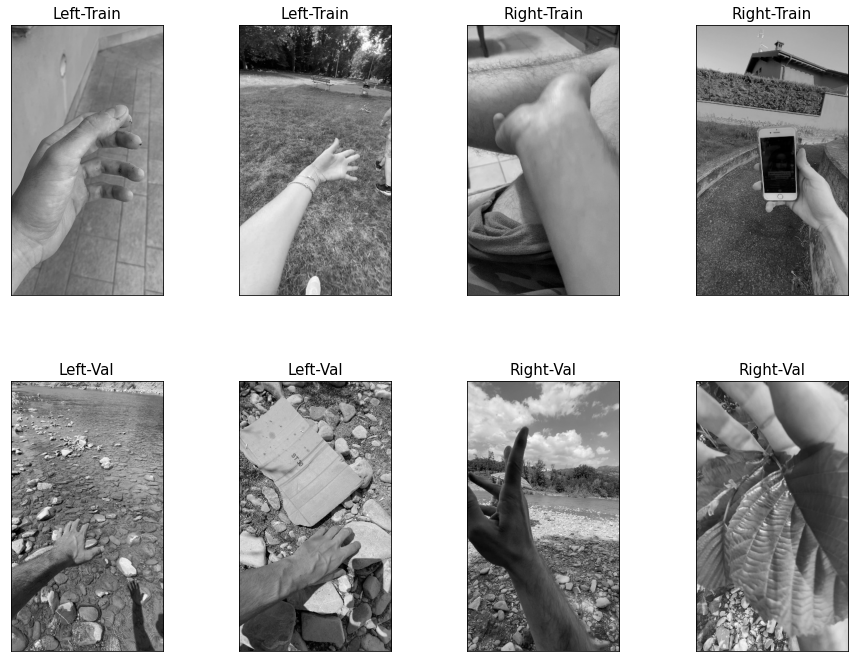

In [1]:
## import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
sample_images = ["Data/Training-Frames/Left/91.22843624056465_Left.jpg",
                 "Data/Training-Frames/Left/102.34975995482287_Left.jpg",
                 "Data/Training-Frames/Right/16.751151471627868_Right.jpg",
                 "Data/Training-Frames/Right/14.598689821454514_Right.jpg",
                 "Data/Validation-Frames/Left/4957_Left.jpg",
                 "Data/Validation-Frames/Left/9654_Left.jpg",
                 "Data/Validation-Frames/Right/12376_Right.jpg",
                 "Data/Validation-Frames/Right/9967_Right.jpg"]
titles = ["Left-Train"] * 2 + ["Right-Train"] * 2 +  ["Left-Val"] * 2  + ["Right-Val"] * 2
fig = plt.figure(figsize=(15, 12))
index = 1
fig.subplots_adjust(wspace=0.5, hspace=0.2)
for sample_image in sample_images:
    image = cv2.imread(sample_image)
    ax = fig.add_subplot(2, 4, index)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(titles[index - 1], fontdict={"fontsize":15})
    index += 1
plt.show()

In [2]:
# IMPORT WHAT WE NEED
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve, log_loss
import json
import os
import warnings
import pandas as pd
import cv2
import numpy as np
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
%load_ext tensorboard
tf.compat.v1.disable_v2_behavior();

Since the images are too many to fit in memory,  we have to define a function which loads images in batches and feed our CNNs progressively. Such a function can be defined as follows:

In [5]:
def data_generator(input_folder, batch_size, normalization_factor=None, mode="train", data_aumentation=None,
                   rescale=None, verbose=0):
    """
    :param input_folder: Directory from which images flow
    :param batch_size: The dimension of each batch of images
    :param normalization_factor: A multiplication factor used to scale each images's pixel
    :param mode: "train" or "validation", used to determine whether to apply data augmentation or not
    :param data_augmentation: self explained
    :param rescale: Tuple of two elements corresponding to the size of an image. Each image will be rescaled accordingly
    :param verbose: 
    :return: A generator of batch_size images
    """
    right_images = os.listdir(os.path.join(input_folder, "Right/"))
    left_images = os.listdir(os.path.join(input_folder, "Left/"))
    num_of_right_images = len(right_images)
    num_of_left_images = len(left_images)
    right_index = 0
    left_index = 0
    right = True
    print_first = False

    while True:
        images = []
        labels = []

        while len(images) < batch_size:
            # Load in batch left and right hands images in an alternate way. Doing this, the network is trained in a more stable manner
            # (avoid all the left hands first and all the right hands after)
            if right:
                right = False
                image = cv2.imread(os.path.join(input_folder, "Right/" + right_images[right_index]),
                                   cv2.IMREAD_GRAYSCALE)
                labels.append(0)  # Append the label of the loaded image: right -> label 0
                if (not print_first) and (verbose == 1):
                    print(right_images[right_index])
                    print_first = True

                right_index += 1
                if right_index + 1 == num_of_right_images:  # IF WE HAVE LOADED ALL THE IMAGES, RESTART
                    right_index = 0
            else:
                right = True
                image = cv2.imread(os.path.join(input_folder, "Left/" + left_images[left_index]), cv2.IMREAD_GRAYSCALE)
                if (not print_first) and (verbose == 1):
                    print(left_images[left_index])
                    print_first = True
                    
                left_index += 1
                if left_index + 1 == num_of_left_images:
                    left_index = 0
                labels.append(1)

            if rescale is not None:  # Apply rescaling if necessary
                image = cv2.resize(image, rescale)
            images.append(image)

        if (mode == "train") and (data_aumentation is not None):  # If we are training the cnn and the data augmentation parameter is provided, apply it
            images = np.array(images)
            images = images.reshape(batch_size, 256, 144, 1)
            images, labels = next(data_aumentation.flow(np.array(images), labels, batch_size=batch_size))
            yield images, labels
        else:
            images = np.array(images)
            images = images.reshape(batch_size, 256, 144, 1)
            if normalization_factor is not None:
                yield normalization_factor * images, labels
            else:
                yield images, labels
                 

## Models Generation Function
We can now define a function which will help us generate a CNN given some parameters. The following models a very simple **sequential** convolutional neural network:

In [6]:
def leNet(conv_layers, dense_layers, interpose_pooling_layers=False, input_shape=(256, 144, 1)):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(filters=conv_layers[0][0],
                                     kernel_size=(conv_layers[0][1], conv_layers[0][2]),
                                     input_shape=input_shape,
                                     activation="relu"))
    if interpose_pooling_layers:
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    for conv_layer in conv_layers[1:]:
        model.add(tf.keras.layers.Conv2D(filters=conv_layer[0],
                                         kernel_size=(conv_layer[1], conv_layer[2]),
                                         activation="relu"))
        if interpose_pooling_layers:
            model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

    model.add(tf.keras.layers.Flatten())
    for dense_layer in dense_layers:
        model.add(tf.keras.layers.Dense(dense_layer, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    return model

We can now instantiate our first simple CNN as follows:

In [7]:
conv_layers = [(50, 4, 4), (100, 3, 3), (150, 3, 3), (200, 3, 3), (300, 2, 2)]
dense_layers = [400, 500, 600, 700]
PIPELINE_BATCH = 64
PIPELINE_BATCH_TEST = 10
TRAIN_FOLDER = "Data/Training-Frames/"
TEST_FOLDER = "Data/Validation-Frames/"
NUM_OF_TRAIN_IMAGES = len(os.listdir(TRAIN_FOLDER + "Right/")) + len(os.listdir(TRAIN_FOLDER + "Left/"))
NUM_OF_TEST_IMAGES = len(os.listdir(TEST_FOLDER + "Right/")) + len(os.listdir(TEST_FOLDER + "Left/"))
EPOCHS = 10
aug = ImageDataGenerator(width_shift_range=0.04,
                         height_shift_range=0.04,
                         zoom_range=0.2,
                         horizontal_flip=False,
                         rescale=1/255,
                         rotation_range=180)
streaming_pipeline_train = data_generator(input_folder=TRAIN_FOLDER,
                                          data_aumentation=aug,
                                          batch_size=PIPELINE_BATCH,
                                          rescale=(144, 256))

streaming_pipeline_test = data_generator(input_folder=TEST_FOLDER,
                                         data_aumentation=None,
                                         batch_size=PIPELINE_BATCH_TEST,
                                         rescale=(144, 256),
                                         normalization_factor=1/255)

model = leNet(conv_layers=conv_layers,
              dense_layers=dense_layers,
              interpose_pooling_layers=True)

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"], experimental_run_tf_function=False)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 253, 141, 50)      850       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 126, 70, 50)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 68, 100)      45100     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 34, 100)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 32, 150)       135150    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 16, 150)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 14, 200)       2

As can be easily derived, **this convolutional neural network is very complex for the task we are solving here** (200 images in the training set and 40 images in the validation set), but actually the full dataset comprises more than 200000 images. By the way, we can try to fit this model anyway with the data available here and check the performances on this little subset of data:

In [15]:
# Train the model
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="Tensorboard_logs\simple_test")
history = model.fit(x=streaming_pipeline_train,
                    steps_per_epoch=10,
                    epochs=EPOCHS,
                    validation_data=streaming_pipeline_test,
                    validation_steps=int(NUM_OF_TEST_IMAGES / PIPELINE_BATCH_TEST),
                    callbacks=[tensorboard],
                    verbose=2)

Epoch 1/10
Epoch 1/10
10/10 - 55s - loss: 0.6937 - acc: 0.5125 - val_loss: 0.6921 - val_acc: 0.5000
Epoch 2/10
Epoch 1/10
10/10 - 54s - loss: 0.6913 - acc: 0.5328 - val_loss: 0.6785 - val_acc: 0.5750
Epoch 3/10
Epoch 1/10
10/10 - 55s - loss: 0.6524 - acc: 0.6313 - val_loss: 0.6296 - val_acc: 0.6250
Epoch 4/10
Epoch 1/10
10/10 - 55s - loss: 0.6737 - acc: 0.6234 - val_loss: 0.6522 - val_acc: 0.5500
Epoch 5/10
Epoch 1/10
10/10 - 55s - loss: 0.5868 - acc: 0.7125 - val_loss: 0.6897 - val_acc: 0.4750
Epoch 6/10
Epoch 1/10
10/10 - 56s - loss: 0.5539 - acc: 0.7125 - val_loss: 0.6134 - val_acc: 0.6250
Epoch 7/10
Epoch 1/10
10/10 - 55s - loss: 0.4589 - acc: 0.7984 - val_loss: 0.6932 - val_acc: 0.6000
Epoch 8/10
Epoch 1/10
10/10 - 55s - loss: 0.4194 - acc: 0.8062 - val_loss: 0.6108 - val_acc: 0.6250
Epoch 9/10
Epoch 1/10
10/10 - 55s - loss: 0.3262 - acc: 0.8547 - val_loss: 0.9510 - val_acc: 0.5500
Epoch 10/10
Epoch 1/10
10/10 - 58s - loss: 0.2888 - acc: 0.8844 - val_loss: 1.0290 - val_acc: 0.6000

As expected, the CNN defined above is able to learn the little dataset very easily and, as one may argue from these logs, the **accuracy on the validation set is not that meaningful**: indeed, the number of images is so small that is not able to generalize enough on all possible backgrounds or hands positions / types.

---

# Analitycs from Google Cloud Platform
As already mentioned, we used GCP to run all the experiments in this small project. We report here the results starting from:
1. **Model Weights**: After each training, we saved the weights of the model (which has beee presented few slides above);
2. **Training History**: We saved the history of each training, including both validation accuracy and validation loss.

As an example, let's load the weights of the best model we found on GCP and try to classify some images:

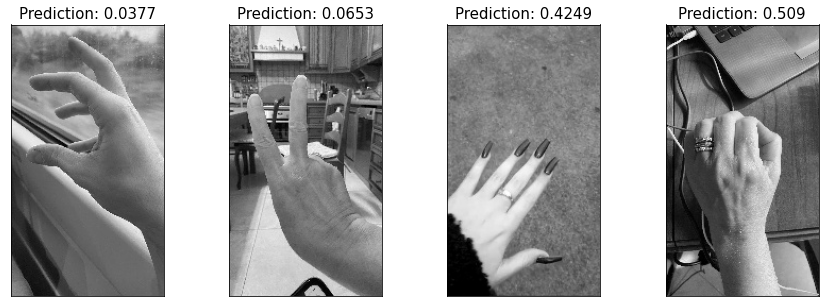

In [95]:
predictions = []
images = ["Data/Sample-Images/Sample-Right.jpg",
          "Data/Sample-Images/Sample-Right_2.jpg",
          "Data/Sample-Images/Sample-Left.JPG",
          "Data/Sample-Images/Sample-Left_2.JPG"]

model.load_weights("Model_Weights/best_model_weights")

for image in images:    
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    if img.shape[0] != 256:
        img = cv2.resize(img, (144, 256))
    img = img.reshape(1, 256, 144, 1)
    img = 1 / 255 * img
    predictions.append(model.predict(x=img))

fig = plt.figure(figsize=(15, 5))
grid_index = 1

for image in images:
    img = cv2.imread(image)
    ax = fig.add_subplot(1, 4, grid_index)
    ax.imshow(img)
    ax.set_title("Prediction: {}".format(str(round(predictions[grid_index - 1][0][0], 4))), fontdict={"fontsize":15})
    ax.set_xticks([])
    ax.set_yticks([])
    grid_index += 1

plt.show();

In [94]:
model.load_weights("Model_Weights/best_model_weights")
images = os.listdir("Data/Validation-Frames/Left")
print(images)
for image in images[1:]:    
    img = cv2.imread("Data/Validation-Frames/Left/" + image, cv2.IMREAD_GRAYSCALE)
    if img.shape[0] != 256:
        img = cv2.resize(img, (144, 256))
    img = img.reshape(1, 256, 144, 1)
    img = 1 / 255 * img
    print(model.predict(x=img))


['0_Left.jpg', '10225_Left.jpg', '10767_Left.jpg', '10945_Left.jpg', '113_Left.jpg', '11600_Left.jpg', '123_Left.jpg', '12_Left.jpg', '23_Left.jpg', '24_Left.jpg', '4726_Left.jpg', '4834_Left.jpg', '4957_Left.jpg', '5338_Left.jpg', '6274_Left.jpg', '7103_Left.jpg', '7708_Left.jpg', '8225_Left.jpg', '9056_Left.jpg', '9654_Left.jpg']
[[0.82869494]]
[[0.8650601]]
[[0.8612228]]
[[0.71826684]]
[[0.7276476]]
[[0.684805]]
[[0.7055417]]
[[0.6998853]]
[[0.6983214]]
[[0.5619124]]
[[0.7050665]]
[[0.7053047]]
[[0.73793674]]
[[0.33640337]]
[[0.5710714]]
[[0.81915265]]
[[0.558517]]
[[0.74272555]]
[[0.5525423]]


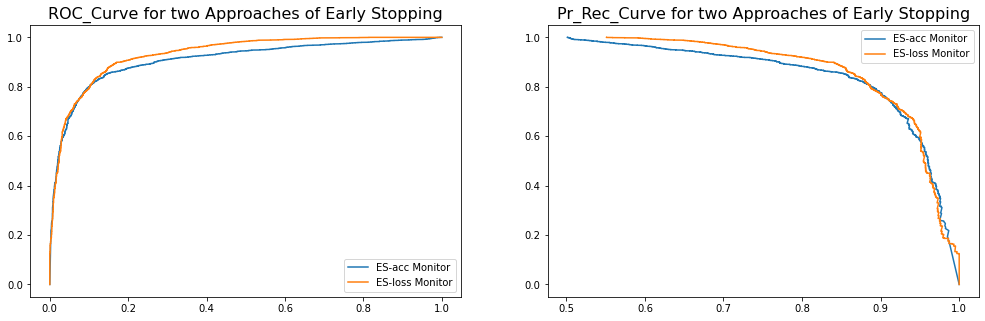

In [10]:
labeled_predictions = pd.read_csv("Models_Predictions/acc_monitor_model_predictions.csv")
labeled_predictions_loss = pd.read_csv("Models_Predictions/loss_monitor_model_predictions.csv")

fig = plt.figure(figsize=(17, 5))
ax = fig.add_subplot(1, 2, 1)
fpr, tpr, thrs = roc_curve(labeled_predictions["Class"], labeled_predictions["Prediction"])
ax.plot(fpr, tpr, label="ES-acc Monitor")
fpr_loss, tpr_loss, thrs_loss = roc_curve(labeled_predictions_loss["Class"], labeled_predictions_loss["Prediction"])
ax.plot(fpr_loss, tpr_loss, label="ES-loss Monitor")
ax.legend(loc='best')
ax.set_title("ROC_Curve for two Approaches of Early Stopping", fontdict={"fontsize":16})
ax = fig.add_subplot(1, 2, 2)
fpr, tpr, thrs = precision_recall_curve(labeled_predictions["Class"], labeled_predictions["Prediction"])
ax.plot(fpr, tpr, label="ES-acc Monitor")
fpr_loss, tpr_loss, thrs_loss = precision_recall_curve(labeled_predictions_loss["Class"], labeled_predictions_loss["Prediction"])
ax.plot(fpr_loss, tpr_loss, label="ES-loss Monitor")
ax.legend(loc='best')
ax.set_title("Pr_Rec_Curve for two Approaches of Early Stopping", fontdict={"fontsize":16})
plt.show()

In [11]:
acc_acc = accuracy_score(labeled_predictions["Class"], labeled_predictions["Predicted Class"])
loss_acc = accuracy_score(labeled_predictions_loss["Class"], labeled_predictions_loss["Predicted Class"])
acc_loss = log_loss(labeled_predictions["Class"], labeled_predictions["Prediction"])
loss_loss = log_loss(labeled_predictions_loss["Class"], labeled_predictions_loss["Prediction"])
print(acc_acc, loss_acc)
print(acc_loss, loss_loss)

0.8527573529411765 0.8588235294117647
0.7802235656191269 0.3715820879239922


In [92]:
predictions = labeled_predictions_loss["Prediction"].values
predictions = list(map(lambda x: round(x, 0), predictions))
labeled_predictions_loss["Predicted Class"] = predictions
labeled_predictions_loss["Predicted Class"] = labeled_predictions_loss["Predicted Class"].apply(int)
labeled_predictions_loss.to_csv("Models_Predictions/loss_monitor_model_predictions.csv", index=False)

In [84]:
img = cv2.imread("Data/Sample-Images/Sample-Right_2.jpg", cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (144, 256))
cv2.imwrite("Data/Sample-Images/Sample-Right_2.jpg", img)

True